# Imports

In [19]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import os
import glob
import numpy as np
import pylab as plb
import tifffile
import h5py
plb.rcParams['pdf.fonttype'] = 42


Populating the interactive namespace from numpy and matplotlib


# load data
Use the tifffile library to construct numpy arrays of the stacks. 

In [20]:
# path info for muscle images
current_dir = os.path.abspath("")
muscle_model_dir = os.path.normpath(os.path.join(current_dir, '..', '..','..'))
segmentation_dir = os.path.join(muscle_model_dir, 'confocal_reference')


In [21]:
# get list of muscles to load 
muscle_list = ['b1', 'b2', 'b3', 'i1', 'i2', 'iii1', 'iii24', 'iii3', 'hg1', 'hg2', 'hg3', 'hg4', 'nm', 'pr']


In [22]:
# load image stacks and store in dict
stack_dict = dict()

# loop over muscles
for muscle in muscle_list:
    tiff_dir = glob.glob(os.path.join(segmentation_dir, '*', 'combined_stack_%s.tiff'%muscle))
    assert len(tiff_dir) == 1, "cannot find path for muscle: %s"%muscle
    
    stack_dict[muscle] = tifffile.TiffFile(tiff_dir[0]).asarray()
    
# also load background image
bkg_path = os.path.join(segmentation_dir, '65G06_brightfield_cuticle.tif')
stack_dict['cuticle'] = tifffile.TiffFile(bkg_path).asarray()


In [23]:
# make max projections for images
mip_dict = dict()

for muscle in muscle_list:
    mip_dict[muscle] = np.max(stack_dict[muscle], axis=0)
    
mip_dict['cuticle'] = stack_dict['cuticle']


In [24]:
# generate hsv and color image for background cuticle
bkgnd_img = mip_dict['cuticle']
img_color = np.dstack((bkgnd_img, bkgnd_img, bkgnd_img))
shape(img_color)
amax(img_color)
from skimage import color
img_hsv = color.rgb2hsv(img_color)

In [25]:
#these functions are used for the image overlays.

def overlay_hue_saturation(overlay,bkgnd,
                       gama = 1.0,
                       color_map = plb.cm.jet,
                       alpha = 0.5):
    """overlay a gray-scale background with a colorized image in hsv space"""
    from skimage import data, color, io, img_as_float
    gama_correct = lambda x: x**gama
    if len(np.shape(bkgnd)) == 2:
        img_color = np.dstack((bkgnd, bkgnd, bkgnd))
    else:
        img_color = bkgnd
        
    if len(np.shape(overlay)) == 2:
        overlay_color = color_map(gama_correct(overlay))[:,:,:3]
        mask = overlay>0
    else:
        overlay_color = overlay
        mask = np.sum(overlay.astype(uint64),axis = 2)>0
    img_hsv = color.rgb2hsv(img_color)
    overlay_hsv = color.rgb2hsv(overlay_color)
    img_hsv[..., 0] += mask*overlay_hsv[..., 0] * alpha
    img_hsv[..., 1] += mask*overlay_hsv[..., 1] * alpha
    img_overlay = color.hsv2rgb(img_hsv)
    return(img_overlay)

def colorized_image(input_img,
                    map_point = 0.5,
                    color_map = plb.cm.jet,
                    alpha = 0.2,
                    gama = 1.0,
                    gain = 1.0):
    """colorize an image using a color taken from a color map and a point on the map,
    used to create families of colorized images that live within a similar color-scheme"""
    from skimage import data, color, io, img_as_float
    gama_correct = lambda x: x**gama
    img = gain*input_img
    img = gama_correct(img)
    img[img>255] = 255
    img = img.astype(uint8)
    bg_color = np.dstack((img, img, img))
    
    mask = img>0
    map_img = mask*map_point
    
    overlay_color = color_map(map_img)[:,:,:3]
    img_hsv = color.rgb2hsv(bg_color)
    
    overlay_hsv = color.rgb2hsv(overlay_color)
    #make hue and saturation of img map to color
    img_hsv[..., 0] += mask*overlay_hsv[..., 0] * alpha
    img_hsv[..., 1] += mask*overlay_hsv[..., 1] * alpha
    img_overlay = color.hsv2rgb(img_hsv)
    return(img_overlay)

In [26]:
#import os
#os.remove(registration_dir + 'max_imgs.h5py')

In [27]:
#lvs = locals()
#import h5py
#max_projections = h5py.File(registration_dir + 'max_imgs.h5py')
#for key,stack in lvs.items():
#    if 'img' in key:
#        k = key.split('_')[0]
#        print k
#        max_projections.create_dataset(k,data = stack,compression = 'gzip',compression_opts = 5)
#max_projections.flush()
#max_projections.close()
#del(max_projections)

# Colorize the max intensity projections
This transforms the max intensity projections into HSV space finds a color and then transforms the data back into RGBA space.

In [30]:
# color setttings for different muscles
# NB: I removed tps, tt, and DVMs but they could be easily added back
b_map = plb.cm.Blues_r
i_map = plb.cm.Purples_r
iii_map = plb.cm.Reds_r
hg_map = plb.cm.Oranges_r
tp_map = plb.cm.Greens_r
pr_map = plb.cm.Greens_r
nm_map = plb.cm.Greens_r

ttm_map = plb.cm.Greens_r

dvm_map = plb.cm.bone_r

cvls = {'b1':0.01,'b2':0.2,'b3':0.4,
        'i1':0.01,'i2':0.2,
        'iii1':0.01,'iii3':0.2,'iii24':0.4,
        'hg1':0.01,'hg2':0.2,'hg3':0.4,'hg4':0.6,
        'tpd':0.01,'tpv':0.1,
        'pr':0.01,'nm':0.01}

cmaps = {'b1':b_map,'b2':b_map,'b3':b_map,
        'i1':i_map,'i2':i_map,
        'iii1':iii_map,'iii3':iii_map,'iii24':iii_map,
        'hg1':hg_map,'hg2':hg_map,'hg3':hg_map,'hg4':hg_map,
        'tpd':tp_map,'tpv':tp_map,
        'pr':pr_map,'nm':nm_map}
       

In [31]:
# make colorized images
colorized_dict = dict()

# loop over muscles
for muscle in muscle_list:
    # some special conditions
    if muscle == 'b3':
        gama = 0.65
        gain = 40.0
    elif muscle == 'i2':
        gama = 0.7
        gain = 10.0
    elif muscle == 'hg1':
        gama = 1.0
        gain = 2.0
    else:
        gama = 1.0
        gain = 1.0
        
    colorized_dict[muscle] = colorized_image(mip_dict[muscle], color_map=cmaps[muscle], 
                                             map_point=cvls[muscle], alpha=1.0, 
                                             gama=gama, gain=gain)


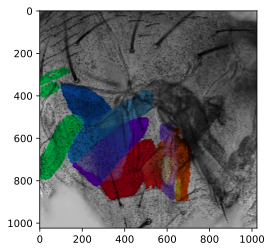

In [41]:
#combine the images using addition
img_sum = 255*np.sum(np.stack(colorized_dict.values()), axis=0)

img_sum[img_sum>255] = 255
img_sum = img_sum.astype(uint8)
imshow(overlay_hue_saturation(img_sum[:,:,:3],bkgnd_img,alpha = 1.0))
display(gcf());close()

The resulting color overlay is a bit of a mess since all the colors get mixed together. To produce an image that is easier to interpret I define function mask_stack that will only combine bits of the image that are within the mask.  I then sequentially apply the function 'mask_stack' to a list of colorized muscle stacks to create a visualization of the muscle population. The order of muscles in the list is important since this determines the way the muscles overlap in the final image. The colorized images of the muscles are then mixed into the grayscale image of the cuticle.

# Another way to colorize
I find the anatomy easier to interpret if the gray scale information from the confocal slices is combined with the segmentation, and the color mixing coming from the overlap is dealt with in a non-linear way.  

In [42]:
def mask_stack(top_img,bottom_img,alpha = 0.5,gain = 15):
    from skimage import data, color, io, img_as_float
    top_hsv = color.rgb2hsv(top_img)
    mask = top_hsv[...,2]/np.max(top_hsv[...,2])
    mask *= gain
    mask[mask>1] = 1
    mask[mask<1] = 0
    mask = np.dstack((mask,mask,mask)) 
    inverse = 1-mask*alpha
    return top_img*mask + bottom_img*inverse


#stacked_muscles = reduce(mask_stack, 
#                          [tpd_colorized,
#                           tpv_colorized,
#                           nm_colorized,
#                           pr_colorized,
#                           b2_colorized,
#                           i1_colorized,
#                           hg4_colorized,
#                           iii24_colorized,
#                           i2_colorized,
#                           hg2_colorized,
#                           hg3_colorized,
#                           iii3_colorized,
#                           iii1_colorized,
#                           b1_colorized,
#                           b3_colorized,
#                           hg1_colorized,
#                           ttm_colorized,
#                           DVM1_colorized,
#                           DVM2_colorized,
#                           DVM3_colorized])

def get_summary_img(muscle_list):
    stacked_muscles = reduce(mask_stack,muscle_list)   
    gama = 1.5
    gama_correct = lambda x: x**gama
    cut_gamma = gama_correct(bkgnd_img)+600
    cuticle = (np.dstack((cut_gamma,cut_gamma,cut_gamma))*0.03).astype(uint8)
    muscles = (stacked_muscles*0.9*255)
    sumimg = cuticle+muscles
    sumimg[sumimg>255] = 255
    sumimg = sumimg.astype(uint8)
    return sumimg
    #imshow(sumimg)
    #display(gcf());close()

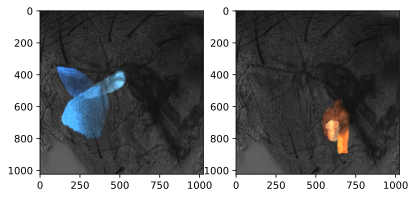

In [43]:
#this creates a bunch of summary images with different sets of muscles displayed.
#first create lists of colorized images that will be combined together using the mask_stak procedure.

figure(figsize = (10,10))
bkgd = []

b_musc = [colorized_dict[muscle] for muscle in ['b2', 'b1', 'b3']]  #  [b2_colorized,b1_colorized,b3_colorized]

i_musc = [colorized_dict[muscle] for muscle in ['i1', 'i2']]  #[i1_colorized,i2_colorized]

iii_musc = [colorized_dict[muscle] for muscle in ['iii1', 'iii24', 'iii3']]  # [iii1_colorized,iii24_colorized,iii3_colorized]

hg_musc = [colorized_dict[muscle] for muscle in ['hg4', 'hg2', 'hg3', 'hg1']]  # [hg4_colorized,hg2_colorized, hg3_colorized,hg1_colorized]

# t_musc = [tpd_colorized,tpv_colorized, ttm_colorized]

b_i_musc = [colorized_dict[muscle] for muscle in ['b2', 'i1', 'i2', 'b1', 'b3']] #  [b2_colorized,i1_colorized,i2_colorized,b1_colorized,b3_colorized]

b_i_iii_musc = [colorized_dict[muscle] for muscle in ['b2', 'i1', 'iii24', 'i2', 'iii3', 'iii1', 'b1', 'b3']] 

b_i_iii_hg_musc =  [colorized_dict[muscle] for muscle in 
                    ['b2', 'i1', 'hg4', 'iii24', 'i2', 'hg2', 'hg3', 'iii3', 'iii1', 'b1', 'b3', 'hg1']] 
               
# b_i_iii_hg_tp_musc = [tpd_colorized,tpv_colorized,b2_colorized,
#                       i1_colorized,hg4_colorized,iii24_colorized,i2_colorized,pr_colorized,
#                       hg2_colorized, hg3_colorized,iii3_colorized,iii1_colorized,
#                       b1_colorized,b3_colorized,hg1_colorized,ttm_colorized]

#now combine them together

gamma = 1.5

sumimg = get_summary_img(b_musc)
tifffile.imsave('b_musc.tiff',sumimg)
subplot(1,3,1);imshow(sumimg)

sumimg = get_summary_img(i_musc)
tifffile.imsave('i_musc.tiff',sumimg)

sumimg = get_summary_img(iii_musc)
tifffile.imsave('iii_musc.tiff',sumimg)

sumimg = get_summary_img(hg_musc)
tifffile.imsave('hg_musc.tiff',sumimg)
subplot(1,3,2);imshow(sumimg)

# sumimg = get_summary_img(t_musc)
# tifffile.imsave('t_musc.tiff',sumimg)

sumimg = get_summary_img(b_i_musc)
tifffile.imsave('b_i_musc.tiff',sumimg)

sumimg = get_summary_img(b_i_iii_musc)
tifffile.imsave('b_i_iii_musc.tiff',sumimg)

sumimg = get_summary_img(b_i_iii_hg_musc)
tifffile.imsave('b_i_iii_hg_musc.tiff',sumimg)

# sumimg = get_summary_img(b_i_iii_hg_tp_musc)
# tifffile.imsave('b_i_iii_hg_tp_musc.tiff',sumimg)
# subplot(1,3,3);imshow(sumimg)

cut_gamma = bkgnd_img**gamma+600
cuticle = (np.dstack((cut_gamma,cut_gamma,cut_gamma))*0.03).astype(uint8)
tifffile.imsave('bkgd.tiff',cuticle)
tifffile.imsave('muscle_viz.tiff',sumimg)


# Construct a geometric model

To define the regions of interest, I find the 2d contours around each muscle. For simplicity I then re-sample the contours to 20 points.

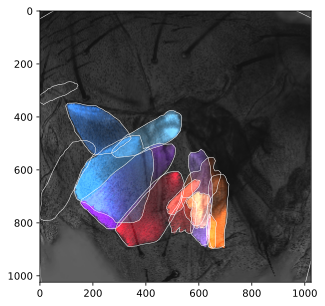

In [44]:
mimgs = mip_dict.copy()

import os
#ad_hoc_masks 
#for fn in os.listdir(registration_dir  + 'ad_hoc_masks/'):
#    mimgs[fn.split('.')[0]] = tifffile.TiffFile(registration_dir + 'ad_hoc_masks/' + fn).asarray()[:,:,1]
model_data = dict()
#construct model
from skimage import measure
from scipy.interpolate import griddata
figure(figsize(5,5))
imshow(sumimg)
for mkey in mimgs.keys():
    img = mimgs[mkey]
    imdim = np.array(shape(img)) + np.array([2,2])
    buff = zeros(imdim)
    buff[1:-1,1:-1] = img
    img = buff
    contours = [measure.find_contours(img,1)[0]]
    for n, contour in enumerate(contours):
        clen = len(contour[:,0])
        x = griddata(np.arange(clen),contour[:,0],np.linspace(clen,20))
        x = x[~isnan(x)]
        x = hstack((x,x[0]))
        x -= 1
        y = griddata(np.arange(clen),contour[:,1],np.linspace(clen,20))
        y = y[~isnan(y)]
        y = hstack((y,y[0]))
        y -= 1
        model_data[mkey] = vstack((y,x))
        plot(y, x,linewidth=0.5,color = 'w')
gca().set_xbound((0,1024))
gca().set_ybound((0,1024))
display(gcf());close()

Now I construct a model and plot it in the reference frame of the confocal image: the position of the three bristles that form the reference frame are hard coded here.

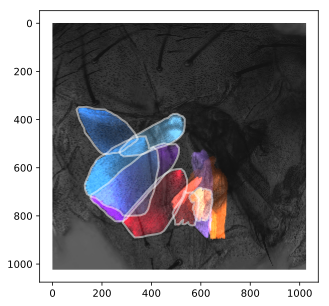

In [45]:
import muscle_model as mm
fig = figure(figsize = (5,5))
imfile = tifffile.TiffFile('muscle_viz.tiff')
sumimg = imfile.asarray()

### manually add position of large setae 
model_data['e1'] = np.array([[ 170.02788104,  326.71685254],
                             [ 380.98203222,  919.92627014]])
model_data['e2'] = array([[ 172.83333333,  332.83333333],
                          [ 551.5       ,  164.83333333]])
e1 = model_data['e1']
e2 = model_data['e2']
muscles = dict()

for key in model_data.keys():
    if not(key in ['e1','e2']):
        muscles[key] = model_data[key]
        
confocal_frame = mm.Frame()
confocal_frame['a1'] = e2[1]-e2[0]
confocal_frame['a2'] = e1[1]-e2[0]
confocal_frame['p'] = e2[0]

#construct a geometric model object from the muscle contours
thorax = mm.GeometricModel(muscles,confocal_frame)

imshow(sumimg)

#now use the ModelView object to plot the contours on the image
thorax_view = mm.ModelViewMPL(thorax)
contour_kwargs = {'b3':{'edgecolor': 'w', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'b1':{'edgecolor': 'w', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'b2':{'edgecolor': 'w', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'i1':{'edgecolor': 'w', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'iii1':{'edgecolor': 'w', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'tpv':{'edgecolor': 'w', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'tpd':{'edgecolor': 'w', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'iii3':{'edgecolor': 'w', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5},
                  'hg4':{'edgecolor': 'w', 'linewidth': 2.0, 'facecolor': 'none','alpha':0.5}}

thorax_view.plot(thorax.frame,contour_kwargs = contour_kwargs)
gca().axis('tight')
savefig('model_view.pdf')
display(gcf());close()

In [46]:
import cPickle as cpkl
f= open('model_data.cpkl','wb')
cpkl.dump(model_data,f)
f.close()

# Blur approximation

I approximate the view of the muscles in the wide field using the volumetric information in the confocal z-series by convolving each slice with a circle of confusion with diameter C.  This is mostly an approximation following the diagram below since we are modeling the entire microscope as a single thin lens. 

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cb/Circle_of_confusion_calculation_diagram.svg" alt="diagram" height="500" width="500"> 

The objective will be focused on some object plane (dotted line) at a distance S1. Ignoring diffraction and aberration, a point source at this plane will then be focused to a point on the imager (solid line) at a distance f1. A point source further from the lens than the object plane (red lines) will then form a blur circle of diameter C on the imager.

The model does a decent job of approximating the focal blur, but because of the approximations I ended up making a few adjustments by hand - increasing the amount of blur - so the the model was more conservative and representative of the images that we collect.

In [78]:
obj_mag = 10.0 #10x objective\n",
#obj_mag = 20.0 #20x objective\n
tube_fl = 200.0 #mm tube lens focal length\n",

obj_fl = tube_fl/obj_mag #mm objective focal length\n",
obj_NA = 0.45 #objective NA\n", for 10x objective
#obj_NA = 0.42 #objective NA\n", for long wd 20x objective

obj_entrance_pupil = 2*obj_fl*obj_NA
voxel_ptch = (0.76/1000.0,0.76/1000.0,2.98/1000.0) #mm\n",
fslice = 25 #focal slice - the slice in the confocal stack that is at the center of focus point in the reconstructed model \n",
#working_distance = 4.0 #mm, not used in the calculation\n",
wavelength = 530.0/(1000*1000) #mm\n",
#airy_disk = 2*(0.61*wavelength)/obj_NA\n",
airy_disk = wavelength/(2*obj_NA) #diffraction limit\n",
#The airy disk should be around the confocal-image voxel pitch \n",
airy_disk = airy_disk*10 #the model seems predict a crisper image for the\n",
# focal slice than what we collect with our 
# wide-field objective - possibly due to motion\n"

def make_kernel(diam):
    """construct a circular convolution kernel """
    diam_pix = diam/voxel_ptch[0]
    x,y = meshgrid(range(-512,512),range(-512,512))
    kernel = ((sqrt(x**2+y**2)>diam_pix).astype(float)-1)*-1
    return kernel

def get_cof_diam(slice_idx):
    """just add the airy disk to the blur circle so the slice that is in focus is blurred\n",
    by the diffraction limit. Though this should be a more complicated kernal than a circle\n",
    the the slices above and below the focal plain are primarily blurred due to the effects
    of a blur circle so we use a circular kernel"""
    slice_delta = (slice_idx-fslice)*voxel_ptch[2]
    return obj_entrance_pupil*abs(slice_delta)/obj_fl + airy_disk

def blur_slice(img,idx):
    """blurr a slice"""
    img = (img>0).astype(float)
    from scipy.signal import fftconvolve 
    cof_diam = get_cof_diam(idx)
    kernel = make_kernel(cof_diam)
    img_out = fftconvolve(img,kernel,mode = 'same')
    return img_out*float(sum(img))/float(sum(img_out))

In [79]:
print(airy_disk)

0.00588888888889


# example of blurred componet

In [80]:
stack = stack_dict['b1']
blur_model = [blur_slice(stack[idx],idx) for idx in range(shape(stack)[0])]

/home/sam/anaconda3/envs/muscle_imaging/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in divide


In [81]:
blur_model = np.array(blur_model)
blur_model[isnan(blur_model)] = 0

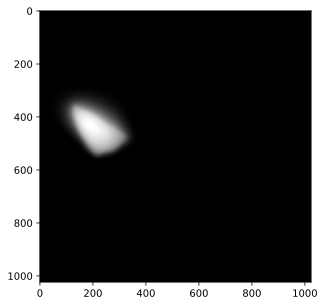

In [82]:
imshow(sum(blur_model,axis = 0),cmap = cm.gray)

In [83]:
#Blurr all the stacks (takes a while to run)
model_dict = dict()
for key in muscle_list:
    stack = stack_dict[key]
    print key
    model = [blur_slice(stack[idx],idx) for idx in range(shape(stack)[0])]
    model = np.array(model)
    model[isnan(model)] = 0
    model_dict[key] = model

b1


/home/sam/anaconda3/envs/muscle_imaging/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in divide


b2
b3
i1
i2
iii1
iii24
iii3
hg1
hg2
hg3
hg4
nm
pr


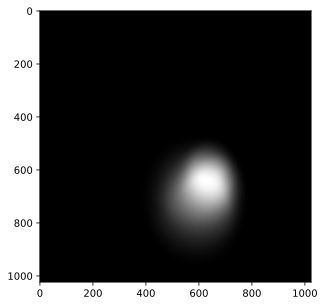

In [84]:
# check hg muscles
imshow(sum(model_dict['hg1'],axis = 0),cmap = cm.gray)

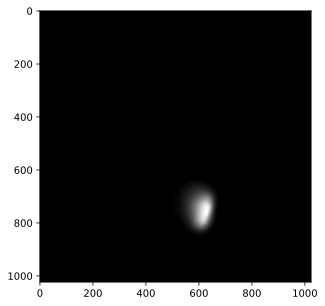

In [85]:
# check hg muscles
imshow(sum(model_dict['hg4'],axis = 0),cmap = cm.gray)
    

# Save the model

In [86]:
import h5py
import os

In [87]:
try:
    os.remove('volumetric_model_nikon_10x.hdf5')
except OSError:
    pass
model_file = h5py.File('volumetric_model_nikon_10x.hdf5','a')

In [88]:
for key,stack in model_dict.items():
    model_file.create_dataset(key, data = stack,compression="gzip", compression_opts=5)

In [89]:
try:
    os.remove('flatened_model_10x_nikon.hdf5')
except OSError:
    pass
flattened_file = h5py.File('flatened_model_10x_nikon.hdf5','a')
for key,stack in model_dict.items():
    flattened_file.create_dataset(key,data = np.sum(stack,axis = 0),compression = 'gzip',compression_opts = 5)

In [90]:
model_file.flush()
model_file.close()

In [91]:
flattened_file.flush()
flattened_file.close()